In [1]:
import pickle
import gzip

with gzip.open('train.pkl', 'rb') as f:
    data = pickle.load(f)

In [2]:
for i in range(len(data)):
    print(data[i]['video'].shape, data[i]['dataset'])


(112, 112, 334) amateur
(112, 112, 177) amateur
(112, 112, 195) amateur
(112, 112, 181) amateur
(112, 112, 211) amateur
(112, 112, 209) amateur
(112, 112, 129) amateur
(112, 112, 179) amateur
(112, 112, 168) amateur
(112, 112, 151) amateur
(112, 112, 113) amateur
(112, 112, 214) amateur
(112, 112, 151) amateur
(112, 112, 166) amateur
(112, 112, 210) amateur
(112, 112, 118) amateur
(112, 112, 177) amateur
(112, 112, 171) amateur
(112, 112, 258) amateur
(112, 112, 173) amateur
(112, 112, 190) amateur
(112, 112, 109) amateur
(112, 112, 206) amateur
(112, 112, 196) amateur
(112, 112, 114) amateur
(112, 112, 176) amateur
(112, 112, 177) amateur
(112, 112, 190) amateur
(112, 112, 201) amateur
(112, 112, 178) amateur
(112, 112, 128) amateur
(112, 112, 215) amateur
(112, 112, 174) amateur
(112, 112, 221) amateur
(112, 112, 150) amateur
(112, 112, 179) amateur
(112, 112, 141) amateur
(112, 112, 140) amateur
(112, 112, 184) amateur
(112, 112, 159) amateur
(112, 112, 154) amateur
(112, 112, 172) 

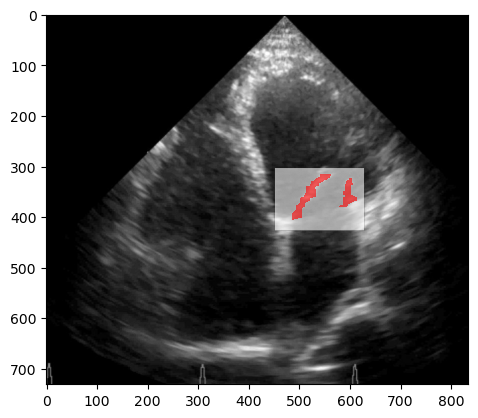

In [3]:
# expert
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(data[57]['video'][:,:,2], cmap='gray')
height = data[57]['video'].shape[0]

box = np.zeros((data[57]['video'].shape[0], data[57]['video'].shape[1], 4))
box[data[57]['box']] = [1, 1, 1, 0.6]
plt.imshow(box)

overlay = np.ma.masked_where(~data[57]['label'][:,:,2], data[57]['label'][:,:,2])
plt.imshow(overlay, cmap='autumn', interpolation='nearest', alpha=0.6)

plt.show()

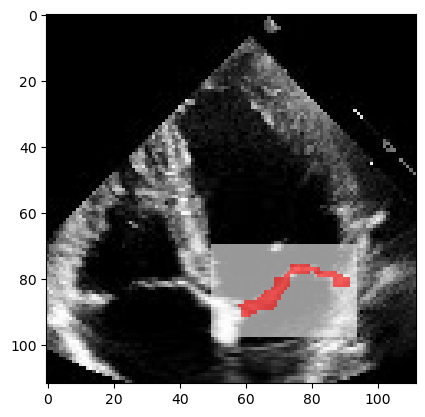

In [4]:
# amateur
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(data[0]['video'][:,:,15], cmap='gray')

box = np.zeros((112, 112, 4))
box[data[0]['box']] = [1, 1, 1, 0.6]
plt.imshow(box)

overlay = np.ma.masked_where(~data[0]['label'][:,:,15], data[0]['label'][:,:,15])
plt.imshow(overlay, cmap='autumn', interpolation='nearest', alpha=0.6)

plt.show()

In [5]:
# distinguish expert and amateur
expert = [item for item in data if item.get('dataset') == 'expert']
amateur = [item for item in data if item.get('dataset') == 'amateur']

In [6]:
# extract the marked frames
expert_marked = []

for data in expert:
    video_name = data['name']
    video = data['video']
    box = data['box']
    label = data['label']
    frames = data['frames']

    for idx, frame_idx in enumerate(frames):
        name_frame = f"{video_name}_{frame_idx}"
        marked_frame = video[:, :, frame_idx]
        label_frame = label[:, :, frame_idx]
        expert_marked.append({
            'name_frame': name_frame,
            'frame': marked_frame,
            'box': box,
            'label': label_frame
        })

amateur_marked = []

for data in amateur:
    video_name = data['name']
    video = data['video']
    box = data['box']
    label = data['label']
    frames = data['frames']

    for idx, frame_idx in enumerate(frames):
        name_frame = f"{video_name}_{frame_idx}"
        marked_frame = video[:, :, frame_idx]
        label_frame = label[:, :, frame_idx]
        amateur_marked.append({
            'name_frame': name_frame,
            'frame': marked_frame,
            'box': box,
            'label': label_frame
        })

In [32]:
print(len(expert_marked))
print(len(amateur_marked))
print(expert_marked[0])

57
138
{'name_frame': 'YEZ7BPLZW0_20', 'frame': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'box': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'label': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}


In [33]:
from sklearn.model_selection import train_test_split
train_expert, val_expert = train_test_split(expert_marked, test_size=0.2, random_state=42)
train_amateur, val_amateur = train_test_split(amateur_marked, test_size=0.2, random_state=42)

In [38]:
print(len(train_expert))
print(len(val_expert))
print(len(train_amateur))
print(len(val_amateur))

45
12
110
28


In [39]:
with open('val_expert.pkl', 'wb') as f:
    pickle.dump(val_expert, f)
with open('val_amateur.pkl', 'wb') as f:
    pickle.dump(val_amateur, f)

In [56]:
# data augmentation(based on marked frames)

import albumentations as A
import numpy as np

def convert_box_to_coordinates(box):

    y_indices, x_indices = np.where(box)
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()

    return [x_min, y_min, x_max, y_max]

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5), 
    A.RandomBrightnessContrast(p=0.5),  
    A.GaussNoise(var_limit=(10, 50), p=0.2),   
    A.CoarseDropout(max_holes=5, max_height=20, max_width=20, p=0.3), 
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),  
    A.ElasticTransform(alpha=1, sigma=50, p=0.2) 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bbox_labels'], min_visibility=0.1))

def augment_frames(frame_dicts, num_augmented=5):

    augmented_data = []

    for frame_dict in frame_dicts:
        name_frame = frame_dict['name_frame']
        frame = frame_dict['frame']
        label = frame_dict['label']
        box = frame_dict['box']

        if frame.dtype != np.uint8:
            frame = frame.astype(np.uint8)
        label = label.astype(np.uint8)
        box_coordinates = convert_box_to_coordinates(box)


        for aug_idx in range(num_augmented):
            try:
                augmented = transform(image=frame, mask=label, bboxes=[box_coordinates], bbox_labels=[0])
                augmented_frame = augmented['image']
                augmented_label = augmented['mask']
                augmented_box = augmented['bboxes'][0]

                augmented_label = augmented_label > 0


                augmented_box_bool = np.zeros_like(label, dtype=bool)
                x_min, y_min, x_max, y_max = map(int, augmented_box)
                augmented_box_bool[y_min:y_max + 1, x_min:x_max + 1] = True

                augmented_data.append({
                    'name_frame': f"{name_frame}_aug{aug_idx}",
                    'frame': augmented_frame,
                    'box': augmented_box_bool,
                    'label': augmented_label
                })
            except Exception as e:
                print(f"Error processing frame {name_frame}: {e}")
    return augmented_data

expert_augmented = augment_frames(train_expert, num_augmented=5)
amateur_augmented = augment_frames(train_amateur, num_augmented=5)

In [62]:
print(len(expert_augmented))
print(len(amateur_augmented))

225
550


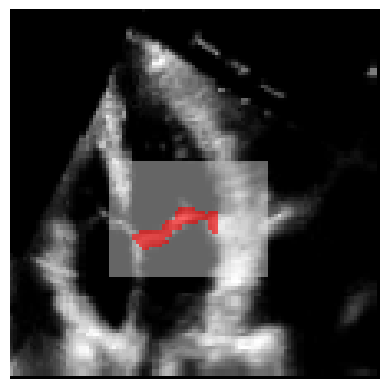

In [63]:
# frames after augmentation
frame = amateur_augmented[50]['frame']
label = amateur_augmented[50]['label']
box = amateur_augmented[50]['box']

plt.imshow(frame, cmap='gray')

box_overlay = np.zeros((frame.shape[0], frame.shape[1], 4))
box_overlay[box] = [1, 1, 1, 0.4]
plt.imshow(box_overlay)

label_overlay = np.zeros((frame.shape[0], frame.shape[1], 4))
label_overlay[label] = [1, 0, 0, 0.6]
plt.imshow(label_overlay)

plt.axis('off')
plt.show()

In [65]:
with open('train_expert.pkl', 'wb') as f:
    pickle.dump(train_expert+expert_augmented, f)

In [66]:
with open('train_amateur.pkl', 'wb') as f:
    pickle.dump(train_amateur+amateur_augmented, f)